In [1]:
import os

# Use the first GPU (index starts from 0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Rest of your code...

In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random
import seaborn as sns
plt.rcParams['figure.constrained_layout.use'] = True

sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
#train test split
from sklearn.model_selection import train_test_split    


In [3]:
URL = "https://gist.githubusercontent.com/ucals/" + "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"+ "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"+ "osic_pulmonary_fibrosis.csv"


In [4]:
train = pd.read_csv(URL)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
x_train, x_test, y_train, y_test = train_test_split(train['Weeks'], train['FVC'], train_size=0.8, random_state=42)
#print size of train and test data
print("x_train size:", x_train.shape)
print("x_test size:", x_test.shape)

x_train size: (1239,)
x_test size: (310,)


In [6]:
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
x_train.head()

,Weeks
1249,25
1048,22
1159,69
818,34
741,0


In [7]:
x_train = x_train.values
y_train = y_train.values


In [8]:
x_test = x_test.values
y_test = y_test.values

In [9]:
#do linear regression from sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train.reshape(-1,1), y_train)

LinearRegression()

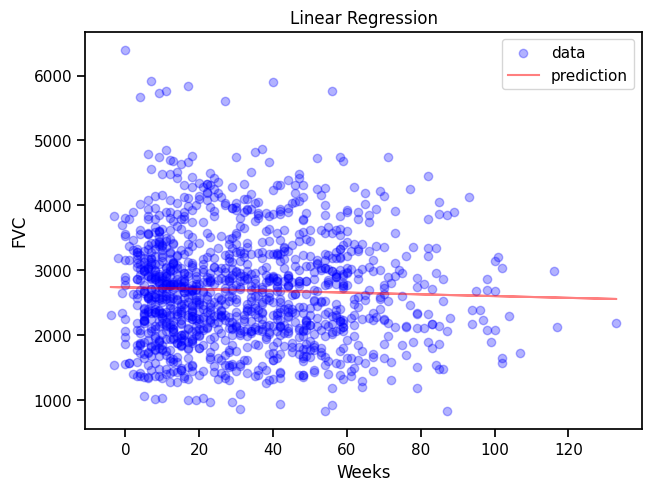

In [10]:
plt.scatter(x_train, y_train, color='blue', label='data', alpha=.3)
plt.plot(x_train, lr.predict(x_train.reshape(-1,1)), color='red', label='prediction', alpha=.5)
plt.title('Linear Regression')
plt.xlabel('Weeks')
plt.ylabel('FVC')
plt.legend();

In [11]:
#check the performnace of the model
from sklearn.metrics import mean_squared_error
y_pred = lr.predict(x_test.reshape(-1,1))
maes={}
maes['Linear Regression'] = mean_squared_error(y_test, y_pred)
maes


{'Linear Regression': 599521.0377904548}

In [12]:
import numpyro
import numpyro.distributions as dist
from jax import random

## pooled model 

$$
\alpha \sim \mathcal{N}(0, 500) \\
\beta \sim \mathcal{N}(0, 500) \\
\alpha_{j} \sim \text{HalfNormal}(100) \\
FVC_{i} \sim \mathcal{N}(\alpha + \alpha, \beta.Weeks) \\
$$
where $j$ is the patient id

In [13]:
def pooled_modeled(sample_weeks,sampled_fvc=None):
    alpha=numpyro.sample('alpha',numpyro.distributions.Normal(0.,500.))
    beta=numpyro.sample('beta',numpyro.distributions.Normal(0.,500.))
    sigma=numpyro.sample('sigma',numpyro.distributions.HalfNormal(100.))
    with numpyro.plate("samples",len(sample_weeks)):
        fvc = numpyro.sample('fvc',numpyro.distributions.Normal(alpha+beta*sample_weeks,sigma),obs=sampled_fvc)
    return fvc    

In [14]:
# numpyro.render_model(pooled_modeled, model_kwargs={"sample_weeks" : x_train }, render_distributions=True)

In [16]:
from numpyro.infer import MCMC, NUTS, Predictive
nuts_kernel = NUTS(pooled_modeled)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0) 
mcmc.run(rng_key,sample_weeks=x_train,sampled_fvc=y_train)   
# posterior_samples = mcmc.get_samples()


: 

In [ ]:
import arviz as az
idata = az.from_numpyro(mcmc)
az.plot_trace(idata,compact=True);

In [ ]:
az.summary(idata,round_to=2)

In [ ]:
predictive= Predictive(pooled_modeled,mcmc.get_samples())

In [ ]:
predictive  

In [ ]:
predictions = predictive(random.PRNGKey(0),sample_weeks=x_test)

In [ ]:
predictions['fvc'].shape

In [ ]:
pd.DataFrame(predictions['fvc']).head()

In [ ]:
#plot the mean of the predictions silple line plot
plt.plot(x_test, predictions['fvc'].mean(axis=0), color='green', label='prediction', alpha=.5)
plt.title('Linear Regression')
plt.xlabel('Weeks')
plt.ylabel('FVC')
plt.legend();

